In [1]:
import time
import numpy as np
import yaml
import sys
import awkward as ak
import uproot as ur
import matplotlib.pyplot as plt
import math
import matplotlib as mpl
from numpy import genfromtxt
import vector

sys.path.append('/home/mjovanovic/Work/LCStudies')
sys.path.append('/home/mjovanovic/Work/PointNet_Segmentation/')
from utils.particle_data_visualize_plot_utils import *
from utils.track_metadata import *
from utils.data_processing_util import *

In [2]:
# TODO: move to helper functions file??

class_colour = [
    "#F2705D", # track of interest
    "#440154FF", # other charged particles
    "#FDE725FF", # pi0
    "#009fdf", # other neutral hadrons
]

class_labels = [
    "focused tracked",
    "other tracked",
    "pi0",
    "other neutral had"
]

def plot_proccessed_cells_in_line(x, y, z, cell_data, title, xlabel, ylabel, zlabel, colour_theme, bar_label, event_idx=None, vmin=None, vmax=None, same_axis=True, add_track=False, add_topo=False):
    fig = plt.figure()
    fig.patch.set_facecolor('white')
    fig.set_size_inches(5*len(cell_data), 5)
    for i, cell_data_i in enumerate(cell_data):
        ax = fig.add_subplot(1, len(cell_data), i + 1, projection='3d')
        x_i = x[i] if len(x) > 1 else x[0]
        y_i = y[i] if len(y) > 1 else y[0]
        z_i = z[i] if len(z) > 1 else z[0]
        xlabel_i = xlabel[i] if len(xlabel) > 1 else xlabel[0]
        ylabel_i = ylabel[i] if len(ylabel) > 1 else ylabel[0]
        zlabel_i = zlabel[i] if len(zlabel) > 1 else zlabel[0]
        title_i = title[i] if len(title) > 1 else title[0]

        if title[i] == "Clustered cells":
            for clus_idx in range(2):#range(0, np.max(processed_event_data["clus_idx"][event_idx]) + 1):
                ax.scatter(processed_event_data["z"][event_idx][processed_event_data["clus_idx"][event_idx] == clus_idx], processed_event_data["x"][event_idx][processed_event_data["clus_idx"][event_idx] == clus_idx], processed_event_data["y"][event_idx][processed_event_data["clus_idx"][event_idx] == clus_idx], label=["pi class", "pi/pi class"][clus_idx], color=pastel_colors[clus_idx])
            ax.legend()
            
        elif bar_label[i] == "Pi+/- frac class" or bar_label[i] == "Pred EM frac class":
            cut_em_class = np.array(cell_data_i) == 1
            clus_x = np.array(x_i)
            clus_y = np.array(y_i)
            clus_z = np.array(z_i)
            ax.scatter(clus_z[cut_em_class], clus_x[cut_em_class], clus_y[cut_em_class], color="fuchsia")
            ax.scatter(clus_z[~cut_em_class], clus_x[~cut_em_class], clus_y[~cut_em_class], color="cyan")  
        #elif title[i] == "Cluster EM probability":
        #    print("not loaded atm")
        elif title[i] == "Input point data":
            p = ax.scatter(z_i, x_i, y_i, c=cell_data_i, vmin=vmin[i], vmax=vmax[i], cmap=colour_theme[i], zorder=1, norm=mpl.colors.LogNorm())
            #if bar_label[i] != "EM frac class":
            #fig.colorbar(p, label=bar_label[i], fraction=0.025, pad=0.15)
        elif title[i] == "Cell classes": # 0 - track of interest, 1 - other charged particles, 2 - pions, 3 - other neutral hadrons
            for class_i in range(4):
                cut_class = np.array(cell_data_i) == class_i
                ax.scatter(np.array(z_i)[cut_class], np.array(x_i)[cut_class], np.array(y_i)[cut_class], color=class_colour[class_i], label=class_labels[class_i])
            ax.legend()
        else:
            p = ax.scatter(z_i, x_i, y_i, c=cell_data_i, vmin=vmin[i], vmax=vmax[i], cmap=colour_theme[i], zorder=1)
            #if bar_label[i] != "EM frac class":
            #fig.colorbar(p, label=bar_label[i], fraction=0.025, pad=0.15)
        
        if add_track: #and (title[i] == "Input point data" or title[i] == "Input point data" or title[i] == "Fraction of cell energy from pi" or title[i] == "Cell truth classes"):
            #print(event_idx)
            for track_idx, track_classes in enumerate(processed_event_track_data["track_classes"][event_idx]):
                is_track_point = track_classes != 0
                is_track_point = np.array(is_track_point)
                
                if np.count_nonzero(is_track_point):
                    #print(np.array(track_classes)[is_track_point])
                    colour = "black" if np.array(track_classes)[is_track_point][0] == 1 else "mediumorchid"
                    ax.scatter(np.array(processed_event_track_data["z"][event_idx][track_idx])[is_track_point], np.array(processed_event_track_data["x"][event_idx][track_idx])[is_track_point], np.array(processed_event_track_data["y"][event_idx][track_idx])[is_track_point], color=colour)
                    ax.plot(np.array(processed_event_track_data["z"][event_idx][track_idx])[is_track_point], np.array(processed_event_track_data["x"][event_idx][track_idx])[is_track_point], np.array(processed_event_track_data["y"][event_idx][track_idx])[is_track_point], color=colour)

            ax.set_xlim(np.min(z_i), np.max(z_i))
            ax.set_ylim(np.min(x_i), np.max(x_i))
            ax.set_zlim(np.min(y_i), np.max(y_i))

        if add_topo and title[i] == "Predicted classes (+ clusters)":
            for clus_idx in range(0, np.max(processed_event_data["clus_idx"][event_idx]) + 1):
                ax.scatter(processed_event_data["z"][event_idx][processed_event_data["clus_idx"][event_idx] == clus_idx], processed_event_data["x"][event_idx][processed_event_data["clus_idx"][event_idx] == clus_idx], processed_event_data["y"][event_idx][processed_event_data["clus_idx"][event_idx] == clus_idx], marker=",", s=90, alpha=0.2, zorder=-1, label="cluster " + str(clus_idx + 1), color=pastel_colors[clus_idx])
            ax.legend()
        ax.set_xlabel(xlabel_i)
        ax.set_ylabel(ylabel_i)
        ax.set_zlabel(zlabel_i)
        plt.title(title_i)
    plt.show()


# plot 3d event info
def plot_event_3d_info(event_idx):#, pipm_frac, class_pipm_frac, preds):
    x = processed_event_data["x"][event_idx]
    y = processed_event_data["y"][event_idx] 
    z = processed_event_data["z"][event_idx]
    
    title = ["Sampling layers", "Input point data"]#, "Fraction of cell energy from pi", "Clustered cells", "Cell truth classes", "Cluster EM probability", "Predicted classes", "Predicted classes (+ clusters)"]
    xlabel = ["z"]
    ylabel = ["x"]
    zlabel = ["y"]

    colour_theme = [plt.cm.tab20b, plt.cm.magma]#, plt.cm.viridis_r, None, plt.cm.viridis_r, plt.cm.viridis_r, plt.cm.viridis_r, plt.cm.viridis_r]
    bar_label = ["Sampling layers", "Cell energy (GeV)"]#, "pi energy frac", "", "Truth Pi0 frac class",  "EM probability", "Predicted classes", "Predicted classes"]
    vmin = [0, None , 0, None, 0, 0, 0, 0]
    vmax = [23, None, 1, None, 1, 1, 1, 1]
    cell_data = [processed_event_data["sampling_layer"][event_idx],  10**(np.array(processed_event_data["cell_E"][event_idx]) + LOG_ENERGY_MEAN)]#, pipm_frac, None, class_pipm_frac, processed_event_data["clus_em_prob"][event_idx], preds, preds]
    #cell_data = [processed_event_data["sampling_layer"][event_idx],  processed_event_data["cell_E"][event_idx], pipm_frac, None, class_pipm_frac, None, preds, preds]
    
    #plot_proccessed_cells_in_line([x], [y], [z], cell_data[:4], title[:4], xlabel, ylabel, zlabel, colour_theme[:4], bar_label[:4], event_idx, vmin[:4], vmax[:4], add_track=True, add_topo=True)
    #plot_proccessed_cells_in_line([x], [y], [z], cell_data[4:], title[4:], xlabel, ylabel, zlabel, colour_theme[4:], bar_label[4:], event_idx, vmin[4:], vmax[4:], add_track=True, add_topo=True)
    for i in range(len(title)):
        plot_proccessed_cells_in_line([x], [y], [z], [cell_data[i]], [title[i]], xlabel, ylabel, zlabel, [colour_theme[i]], [bar_label[i]], event_idx, [vmin[i]], [vmax[i]], add_track=True, add_topo=True)
        

In [28]:
# Define delta dataset to load (all dataset features ie. cellEta, sampling layer, track phi, etc. from files separated from the class labels and preds)
delta_dir = "/data/mjovanovic/cell_particle_deposit_learning/delta_npy_files/" # base directory for all delta files
files_name = "delta_full"

include_delta_p_pi0 = True
include_delta_n_pi0 = False
include_delta_p_pipm = False
include_delta_n_pipm = False

len_file = 6000
i_low = 0
i_high = 4
energy_threshold = 0
BATCH_SIZE = 100

LOG_ENERGY_MEAN = -1 # unrounded mean is ~ -0.93
LOG_MEAN_TRACK_MOMETUM = 2

In [29]:
dataset = "delta"
file_names = ["/data/mjovanovic/cell_particle_deposit_learning/delta/delta_processed_test_files/delta_full_len_6000_i_0.npy"]

max_num_tracks = 1 if dataset == "rho" else 2 # just delta and rho dataset processing for now

# load cell geo tree dict
file = ur.open("/data/atlas/data/rho_delta/rho_small.root")
cell_geo_tree = file["CellGeo"]

node_feature_names = cell_geo_tree.keys()[1:7] # 'cell_geo_sampling', 'cell_geo_eta', 'cell_geo_phi', 'cell_geo_rPerp', 'cell_geo_deta', 'cell_geo_dphi'


cell_geo_data = cell_geo_tree.arrays(library='np')
cell_geo_ID = cell_geo_data['cell_geo_ID'][0]
sorter = np.argsort(cell_geo_ID)

# cluster data dict to look up data by feature name
processed_event_data = {}
processed_event_track_data = {}
processed_event_track_flags = []

cell_geo_ID = cell_geo_data['cell_geo_ID'][0]

samples_count = 0
max_cells = 0
num_cells = 0

for feature in [*node_feature_names, "cell_eta", "trackP", "trackEta", "trackPhi", "truthPartE", "truthPartPt", "truthPartEta", "truthPartPhi", 'x', 'y', 'z', 'cell_hitsTruthIndex', 'cell_hitsTruthE', 'frac_pi0_energy', 'class_frac_pi0_energy', 'cell_E', 'cell_E_weight', 'sampling_layer', 'truthPartPt', 'truthPartEta', 'truthPartPhi', 'clus_idx', 'clus_em_prob', 'decay_group', 'cell_labels', 'cell_part_deposit_labels']:#, 'delta_R']:
    processed_event_data[feature] = []

for feature in ['x', 'y', 'z', 'P', 'min_dist', 'min_eta', 'min_phi', 'sampling_layer', 'track_eta', 'track_phi', 'non_null_tracks', 'track_classes']:
    processed_event_track_data[feature] = []

cell_geo_ID = cell_geo_data['cell_geo_ID'][0]


for preprocessed_file_name in file_names:
    events_arr = np.load(preprocessed_file_name, allow_pickle=True).item()
    
    num_events_saved = 0
    max_cells = 0
    num_cells = 0

    num_events = len(events_arr["eventNumber"])
    event_data = events_arr
    
    for event_idx in range(num_events):
        print(event_idx)
        num_tracks = event_data["nTrack"][event_idx]

        if (len(event_data["cluster_cell_ID"][event_idx]) and \
        (dataset == "delta" and 
            (((num_tracks == 1) and (\
                (include_delta_p_pi0 and event_data["decay_group"][event_idx] == decay_group["delta+_p"]) \
                or (include_delta_n_pipm and (event_data["decay_group"][event_idx] == decay_group["delta+_n"] or event_data["decay_group"][event_idx] == decay_group["delta-"])))) or \
            ((num_tracks == 0) and include_delta_n_pi0 and event_data["decay_group"][event_idx] == decay_group["delta0_n"]) or \
            ( (num_tracks == 2) and include_delta_p_pipm and (event_data["decay_group"][event_idx] == decay_group["delta0_p"] or event_data["decay_group"][event_idx] == decay_group["delta++"])))) \
        or (dataset == "rho" and num_tracks == 1)):
            
            if num_tracks > 0:
                x_tracks = []
                y_tracks = []
                z_tracks = []
                eta_tracks = []
                phi_tracks = []
                rPerp_track = []
                non_null_tracks = []
                for track_idx in range(num_tracks):
                    x_tracks.append([])
                    y_tracks.append([])
                    z_tracks.append([])
                    eta_tracks.append([])
                    phi_tracks.append([])
                    rPerp_track.append([])
                    non_null_tracks.append([])
                    # get the eta, phi, and rPerp of each layers hit
                    for layer_name in calo_layers:
                        if has_fixed_r[layer_name]:
                            eta_tracks[track_idx].append(event_data['trackEta_' + layer_name][event_idx][track_idx])
                            phi_tracks[track_idx].append(event_data['trackPhi_' + layer_name][event_idx][track_idx])
                            rPerp_track[track_idx].append(fixed_r[layer_name])
                        else:
                            eta = event_data['trackEta_' + layer_name][event_idx][track_idx]
                            eta_tracks[track_idx].append(eta)
                            phi_tracks[track_idx].append(event_data['trackPhi_' + layer_name][event_idx][track_idx])
                            
                            z = fixed_z[layer_name]
                            aeta = np.abs(eta)
                            rPerp = z*2*np.exp(aeta)/(np.exp(2*aeta) - 1)
                            rPerp_track[track_idx].append(rPerp)
                    
                    # convert each hit to the cartesian coords
                    thetas = [2*np.arctan(np.exp(-eta)) for eta in eta_tracks[track_idx]]
                    x_tracks_i, y_tracks_i, z_tracks_i = spherical_to_cartesian(rPerp_track[track_idx], phi_tracks[track_idx], thetas)
                    x_tracks[track_idx] = x_tracks_i
                    y_tracks[track_idx] = y_tracks_i
                    z_tracks[track_idx] = z_tracks_i

                    non_null_tracks_i = np.full(NUM_TRACK_POINTS, True)

                    # if eta > 4.9 or phi > pi mark the track as null (why??)
                    non_null_tracks_i[(np.abs(eta_tracks[track_idx]) >= 2.5) | (np.abs(phi_tracks[track_idx]) > np.pi)] = False

                    non_null_tracks[track_idx] = non_null_tracks_i

                if dataset == "delta":
                    if len(non_null_tracks) != 2:
                        non_null_tracks = np.concatenate((non_null_tracks, np.full((1, NUM_TRACK_POINTS), False)))
                        x_tracks = np.concatenate((x_tracks, np.full((1, NUM_TRACK_POINTS), False)))
                        y_tracks = np.concatenate((y_tracks, np.full((1, NUM_TRACK_POINTS), False)))
                        z_tracks = np.concatenate((z_tracks, np.full((1, NUM_TRACK_POINTS), False)))
            else:
                non_null_tracks = np.full((max_num_tracks, NUM_TRACK_POINTS), False)
                x_tracks, y_tracks, z_tracks = np.zeros((max_num_tracks, NUM_TRACK_POINTS)), np.zeros((max_num_tracks, NUM_TRACK_POINTS)), np.zeros((max_num_tracks, NUM_TRACK_POINTS))
            

            cell_IDs = event_data['cluster_cell_ID'][event_idx]
            cell_IDs = cell_IDs
            cell_ID_map = sorter[np.searchsorted(cell_geo_ID, cell_IDs, sorter=sorter)]

            # get cluster cell energy
            cell_E = event_data["cluster_cell_E"][event_idx]
            #cell_E = np.log10(cell_E) - LOG_ENERGY_MEAN

            # node features
            node_features = {}
            for feature in node_feature_names:
                node_features[feature] = cell_geo_data[feature][0][cell_ID_map]

            # get cartesian coords
            thetas = [2*np.arctan(np.exp(-eta)) for eta in node_features["cell_geo_eta"]]
            x, y, z = spherical_to_cartesian(node_features["cell_geo_rPerp"], node_features["cell_geo_phi"], thetas)

            # label cells (4 classes)
            # all decay groups only have 2 types particles depositing energy, a proton/neutron and a pion
            if dataset == "delta":
                class_part_idx_1 = 0
                class_part_idx_not_1 = 0

                if event_data["decay_group"][event_idx] == decay_group["delta+_p"]:
                    class_part_idx_1 = part_deposit_type_class["track_of_interest"] # proton
                    class_part_idx_not_1 = part_deposit_type_class["pi0"] # pi0
                elif event_data["decay_group"][event_idx] == decay_group["delta+_n"] or event_data["decay_group"][event_idx] == decay_group["delta-"]:
                    class_part_idx_1 = part_deposit_type_class["other_neutral"] # neutron
                    class_part_idx_not_1 = part_deposit_type_class["track_of_interest"] # pi+/-
                elif event_data["decay_group"][event_idx] == decay_group["delta0_n"]:
                    class_part_idx_1 = part_deposit_type_class["other_neutral"] # neutron
                    class_part_idx_not_1 = part_deposit_type_class["pi0"] # pi0
                # if decay is delta++ or delta0_p then set labels elsewhere (since 2 tracks)

                # get all cells with particle idx 1 (proton/neutron)
                cut_part_idx_1_deposits = (ak.Array(event_data["cluster_cell_hitsTruthIndex"][event_idx]) == 1)
                # get fraction of energy from the proton/neutron (always p/n in a rho event - it deposits some energy and the pion deposits the remaining)
                frac_cell_energy_from_part_idx_1 = ak.sum(ak.Array(event_data["cluster_cell_hitsTruthE"][event_idx])[cut_part_idx_1_deposits], axis=1) / ak.sum(event_data["cluster_cell_hitsTruthE"][event_idx], axis=1)
                # if frac_cell_energy_from_part_idx_1 < 0.5 set label class_part_idx_not_1 else set cell label to class_part_idx_1
                cell_part_deposit_labels = [class_part_idx_not_1 if cell_frac_cell_energy_from_part_idx_1 < 0.5 else class_part_idx_1 for cell_frac_cell_energy_from_part_idx_1 in frac_cell_energy_from_part_idx_1]

            # only pi0 and pi+/- depositing energy -> binary classification
            elif dataset == "rho":
                # if the pi0 deposits the majority of the energy label cell 1 else if pi+/- deposits majority label cell 0
                frac_pi0_energy = ak.sum(event_data["cluster_cell_hitsTruthE"][event_idx][event_data["cluster_cell_hitsTruthIndex"][event_idx] != 1], axis=1)/ak.sum(event_data["cluster_cell_hitsTruthE"][event_idx], axis=1)
                cell_part_deposit_labels = [1 if cell_frac_pi0_energy > 0.5 else 0 for cell_frac_pi0_energy in frac_pi0_energy]


            # if the particle has 2 tracks match the track to the particle closest & threshold that they must be close enough together
            # for delta dataset either delta++ -> proton + pi+/- or delta0 -> proton + pi+/-
            track_part_dist_thresh = 1
            if num_tracks == 2:

                part1_idx = 1 # proton
                part2_idx = 2 # charged pion

                part1_phi = event_data["truthPartPhi"][event_idx][part1_idx]
                part1_eta = event_data["truthPartEta"][event_idx][part1_idx]
                part1_pt = event_data["truthPartPt"][event_idx][part1_idx]

                part2_phi = event_data["truthPartPhi"][event_idx][part2_idx]
                part2_eta = event_data["truthPartEta"][event_idx][part2_idx]
                part2_pt = event_data["truthPartPt"][event_idx][part2_idx]

                track1_phi = event_data["trackPhi"][event_idx][0]
                track1_eta = event_data["trackEta"][event_idx][0]
                track1_pt = event_data["trackPt"][event_idx][0]

                track2_phi = event_data["trackPhi"][event_idx][1]
                track2_eta = event_data["trackEta"][event_idx][1]
                track2_pt = event_data["trackPt"][event_idx][1]

                part1_track1_dist = measure_track_part_dists(track1_phi, track1_eta, track1_pt, part1_phi, part1_eta, part1_pt)
                part1_track2_dist = measure_track_part_dists(track2_phi, track2_eta, track2_pt, part1_phi, part1_eta, part1_pt)
                part2_track1_dist = measure_track_part_dists(track1_phi, track1_eta, track1_pt, part2_phi, part2_eta, part2_pt)
                part2_track2_dist = measure_track_part_dists(track2_phi, track2_eta, track2_pt, part2_phi, part2_eta, part2_pt)

                # either pair part1 with track1 and part2 with track2 or part1 with track2 and part2 with track1
                # or discard event if no pairing exists with both track-part dists < thresh
                paring_one_sum_dist = part1_track1_dist + part2_track2_dist if part1_track1_dist < track_part_dist_thresh and part2_track2_dist < track_part_dist_thresh else 2*track_part_dist_thresh
                paring_two_sum_dist = part1_track2_dist + part2_track1_dist if part1_track1_dist < track_part_dist_thresh and part2_track2_dist < track_part_dist_thresh else 2*track_part_dist_thresh
                
                if max(paring_one_sum_dist, paring_two_sum_dist) >= 2*track_part_dist_thresh:
                    num_tracks = 0
                else:
                    if paring_one_sum_dist < paring_two_sum_dist:
                        pairing_one = True
                    else:
                        pairing_one = False

            track_idx = 0
            added_one_sample = False # for each event add one sample to dataset

            non_null_tracks = np.array(non_null_tracks)
            x_tracks = np.array(x_tracks)
            y_tracks = np.array(y_tracks)
            z_tracks = np.array(z_tracks)
            #non_null_tracks = np.array(flatten_one_layer(non_null_tracks))
            #x_tracks = np.array(flatten_one_layer(x_tracks))
            #y_tracks = np.array(flatten_one_layer(y_tracks))
            #z_tracks = np.array(flatten_one_layer(z_tracks))
            
            x_tracks[~non_null_tracks] = 0
            y_tracks[~non_null_tracks] = 0
            z_tracks[~non_null_tracks] = 0

            cell_has_E_deposit = ak.sum(event_data["cluster_cell_hitsTruthE"][event_idx], axis=1) > 0
            num_cells = len(cell_E[cell_has_E_deposit])
            
            # execute once for 0-1 track, and 2 times for 2 tracks
            while not added_one_sample or track_idx < num_tracks:
                processed_event_data["cell_E"].append(cell_E[cell_has_E_deposit])
                processed_event_data["x"].append(x[cell_has_E_deposit])
                processed_event_data["y"].append(y[cell_has_E_deposit])
                processed_event_data["z"].append(z[cell_has_E_deposit])

                # extra features for analysis
                processed_event_data["clus_idx"].append(ak.Array(event_data["clus_idx"][event_idx][cell_has_E_deposit]))
                processed_event_data["clus_em_prob"].append(ak.Array(event_data["clus_em_prob"][event_idx][cell_has_E_deposit]))
                processed_event_data["sampling_layer"].append(ak.Array(node_features["cell_geo_sampling"][cell_has_E_deposit]))
                processed_event_data["cell_hitsTruthIndex"].append(ak.Array(event_data["cluster_cell_hitsTruthIndex"][event_idx][cell_has_E_deposit]))
                processed_event_data["cell_hitsTruthE"].append(ak.Array(event_data["cluster_cell_hitsTruthE"][event_idx][cell_has_E_deposit]))
                processed_event_data["cell_eta"].append(node_features["cell_geo_eta"])

                processed_event_data["truthPartPt"].append(ak.Array(event_data["truthPartPt"][event_idx]))
                processed_event_data["truthPartE"].append(ak.Array(event_data["truthPartE"][event_idx]))
                processed_event_data["truthPartEta"].append(ak.Array(event_data["truthPartEta"][event_idx]))
                processed_event_data["truthPartPhi"].append(ak.Array(event_data["truthPartPhi"][event_idx]))  

                processed_event_data["trackPhi"].append(ak.Array(event_data["trackPhi"][event_idx]))  
                processed_event_data["trackEta"].append(ak.Array(event_data["trackEta"][event_idx]))  
                processed_event_data["trackP"].append(ak.Array(event_data["trackP"][event_idx]))  

                processed_event_data["decay_group"].append(event_data["decay_group"][event_idx])

                

                if dataset == "delta":
                    track_classes = np.zeros((2, NUM_TRACK_POINTS))
                    track_Ps = np.zeros((2, NUM_TRACK_POINTS))
                else:
                    track_classes = np.zeros((1, NUM_TRACK_POINTS))
                    track_Ps = np.zeros((1, NUM_TRACK_POINTS))
                        
                if num_tracks == 2:
                    # set track_idx to be the track of interest (for track idx 0 track 0 is of interest, else track 1)
                    if track_idx == 0:
                        track_classes[0] = np.ones(NUM_TRACK_POINTS)
                        track_classes[1] = np.full(NUM_TRACK_POINTS, 2)
                    else:
                        track_classes[1] = np.ones(NUM_TRACK_POINTS)
                        track_classes[0] = np.full(NUM_TRACK_POINTS, 2)

                    if (pairing_one and track_idx == 0) or (not pairing_one and track_idx == 1): # pair track 0 and part 1
                        class_part_idx_1 = 0 # track of interest
                        class_part_idx_not_1 = 1 # other tracked charged particle 

                    else: # pairing 1 and track idx == 1 or paring 2 and track idx == 0
                        class_part_idx_1 = 1
                        class_part_idx_not_1 = 0

                    cell_part_deposit_labels = [class_part_idx_not_1 if cell_frac_cell_energy_from_part_idx_1 < 0.5 else class_part_idx_1 for cell_frac_cell_energy_from_part_idx_1 in frac_cell_energy_from_part_idx_1]
                    #print("cell_labels:", cell_labels)
                    track_1_P =  np.log10((event_data["trackP"][event_idx][0])) - LOG_ENERGY_MEAN
                    track_2_P =  np.log10((event_data["trackP"][event_idx][1])) - LOG_ENERGY_MEAN
                    track_Ps[0] = np.full(NUM_TRACK_POINTS, track_1_P)
                    track_Ps[1] = np.full(NUM_TRACK_POINTS, track_2_P)
                
                elif num_tracks == 1:
                    # get tracks momentum readout
                    track_P = np.log10(event_data['trackP'][event_idx][0]) - LOG_MEAN_TRACK_MOMETUM
                    track_Ps[0] = np.full(NUM_TRACK_POINTS, track_P)
                    track_classes[0] = np.ones(NUM_TRACK_POINTS)

                #track_classes = np.array(flatten_one_layer(track_classes))
                #track_Ps = np.array(flatten_one_layer(track_Ps))

                track_classes[~non_null_tracks] = 0
                track_Ps[~non_null_tracks] = 0
                
                # else no tracks => Pt = 0

                processed_event_data["cell_part_deposit_labels"].append(np.array(cell_part_deposit_labels)[cell_has_E_deposit])

                processed_event_track_data["x"].append(x_tracks)
                processed_event_track_data["y"].append(y_tracks)
                processed_event_track_data["z"].append(z_tracks)
                processed_event_track_data["P"].append(track_Ps) # don't normalize for analysis

                # track classes - 0 => point, 1 => track of interest, 2 => other track
                processed_event_track_data["track_classes"].append(track_classes)
                
                if num_cells + NUM_TRACK_POINTS*max_num_tracks > max_cells:
                    max_cells = num_cells + NUM_TRACK_POINTS*max_num_tracks

                num_events_saved += 1
                added_one_sample = True
                track_idx += 1

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69


/tmp/ipykernel_53465/2653465799.py:89: RuntimeWarning: overflow encountered in exp
  rPerp = z*2*np.exp(aeta)/(np.exp(2*aeta) - 1)
/tmp/ipykernel_53465/2653465799.py:89: RuntimeWarning: invalid value encountered in double_scalars
  rPerp = z*2*np.exp(aeta)/(np.exp(2*aeta) - 1)
/tmp/ipykernel_53465/2653465799.py:93: RuntimeWarning: overflow encountered in exp
  thetas = [2*np.arctan(np.exp(-eta)) for eta in eta_tracks[track_idx]]
/usr/local/lib/python3.8/dist-packages/awkward/_connect/_numpy.py:195: RuntimeWarning: invalid value encountered in divide
  result = getattr(ufunc, method)(


70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277
278
279
280
281
282
283
284
285
286
287
288
289
290
291
292
293
294
295
296
297
298
299
300
301
302
303
304
305
306
307
308
309
310
311
312
313
314
315
316
317
318
319
320
321
322
323
324
325
326
32

frac of events with delta+_p decay: 1.0
num cells with 0 deposits: 0.0


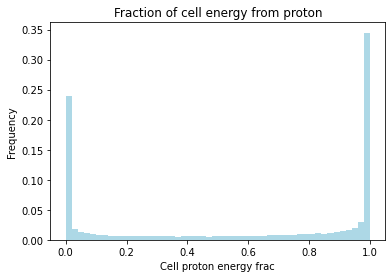

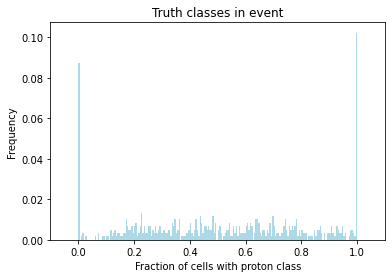

In [30]:
decay_class_1 = 0
decay_class_2 = decay_class_1
p_or_n = "proton" if decay_class_1 == 0 or decay_class_1 == 3 or decay_class_1 == 4 else "neutron"

# 0, 4/3, 1/5, 2
decay_groups = {
    0: "delta+_p",
    1: "delta+_n",
    2: "delta0_n",
    3: "delta0_p",
    4: "delta++",
    5: "delta-",
}   

processed_event_data["cell_hitsTruthIndex"] = ak.Array(processed_event_data["cell_hitsTruthIndex"])
processed_event_data["cell_hitsTruthE"] = ak.Array(processed_event_data["cell_hitsTruthE"])
processed_event_data["decay_group"] = ak.Array(processed_event_data["decay_group"])

event_cut = (processed_event_data["decay_group"] == decay_class_1) | (processed_event_data["decay_group"] == decay_class_2)
print("frac of events with " + decay_groups[decay_class_1] + " decay:", np.count_nonzero(event_cut)/len(event_cut))
cut_p_n_deposits = (processed_event_data["cell_hitsTruthIndex"][event_cut] == 1)
frac_cell_energy_from_p_n = ak.sum(processed_event_data["cell_hitsTruthE"][event_cut][cut_p_n_deposits], axis=2) / ak.sum(processed_event_data["cell_hitsTruthE"][event_cut], axis=2)
frac_cell_energy_from_p_n_flat = np.array(flatten_one_layer(frac_cell_energy_from_p_n))


print("num cells with 0 deposits:", np.count_nonzero(ak.sum(processed_event_data["cell_hitsTruthE"][event_cut], axis=2) == 0) / len(ak.sum(processed_event_data["cell_hitsTruthE"][event_cut], axis=2) == 0))

#print("num nan:", np.count_nonzero(np.isnan(frac_cell_energy_from_p_n_flat)))
#print("num non nan:", np.count_nonzero(~np.isnan(frac_cell_energy_from_p_n_flat)))
plot_hist(np.array(frac_cell_energy_from_p_n_flat), 50, "Fraction of cell energy from " + p_or_n, "Cell " + p_or_n + " energy frac", "Frequency", colour=pastel_colors[decay_class_2])


frac_cells_p_n_class_per_event = np.array([np.count_nonzero(event_frac_cell_energy_from_p_n > 0.5)/len(event_frac_cell_energy_from_p_n) for event_frac_cell_energy_from_p_n in frac_cell_energy_from_p_n])
#frac_cells_p_n_class_per_event = np.array([np.nan if len(event_frac_cell_energy_from_neutron) == 0 else np.count_nonzero(event_frac_cell_energy_from_neutron > 0.5)/len(event_frac_cell_energy_from_neutron) for event_frac_cell_energy_from_neutron in frac_cell_energy_from_neutron])
plot_hist(frac_cells_p_n_class_per_event, 200, "Truth classes in event", "Fraction of cells with " + p_or_n + " class", "Frequency", True, colour=pastel_colors[decay_class_2], xlim=(-0.1,1.1)) # #009fdf


decay group: delta+_p


/tmp/ipykernel_53465/119182854.py:69: UserWarning: Attempting to set identical left == right == 1630.7916338360305 results in singular transformations; automatically expanding.
  ax.set_xlim(np.min(z_i), np.max(z_i))
/tmp/ipykernel_53465/119182854.py:70: UserWarning: Attempting to set identical bottom == top == -746.3372802734375 results in singular transformations; automatically expanding.
  ax.set_ylim(np.min(x_i), np.max(x_i))
/tmp/ipykernel_53465/119182854.py:71: UserWarning: Attempting to set identical bottom == top == 1247.712158203125 results in singular transformations; automatically expanding.
  ax.set_zlim(np.min(y_i), np.max(y_i))


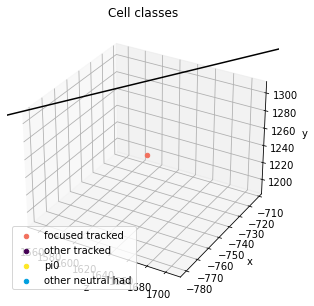

decay group: delta+_p


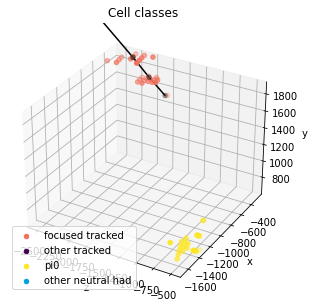

decay group: delta+_p


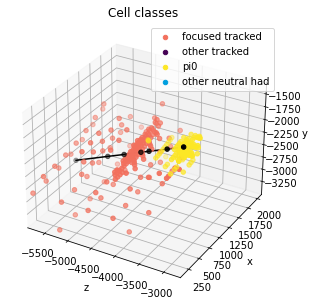

decay group: delta+_p


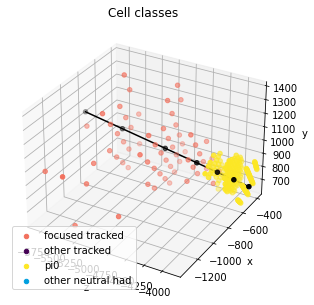

decay group: delta+_p


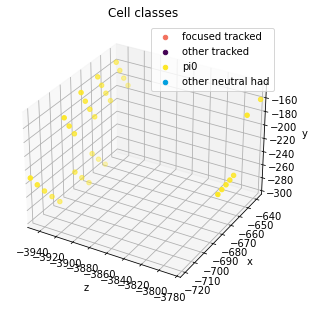

decay group: delta+_p


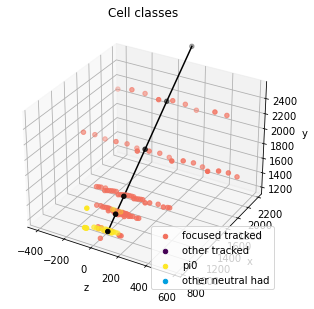

decay group: delta+_p


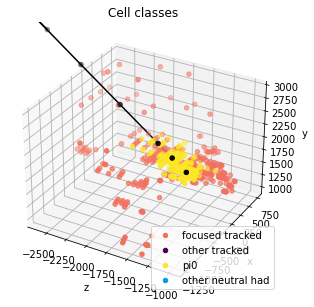

decay group: delta+_p


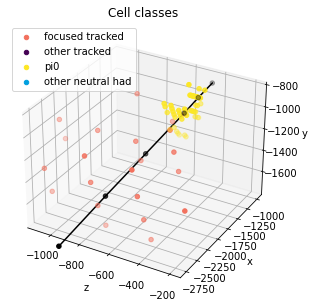

decay group: delta+_p


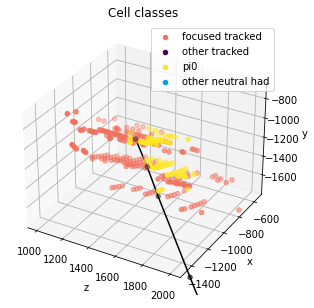

decay group: delta+_p


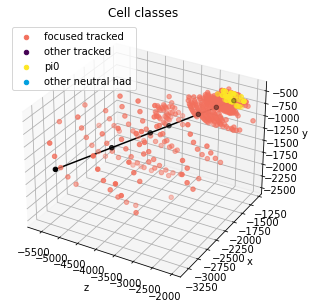

decay group: delta+_p


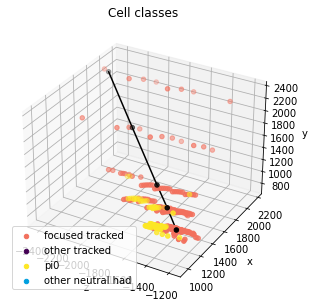

decay group: delta+_p


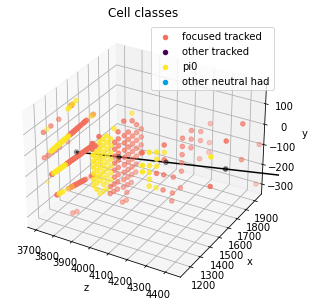

decay group: delta+_p


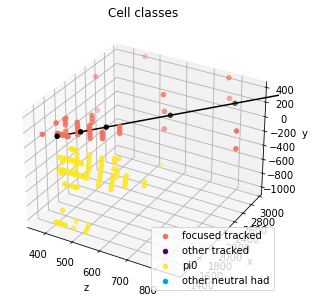

decay group: delta+_p


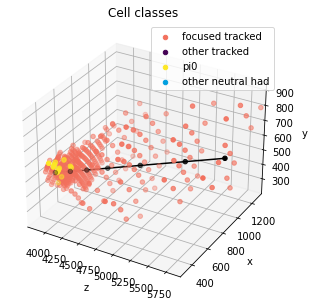

decay group: delta+_p


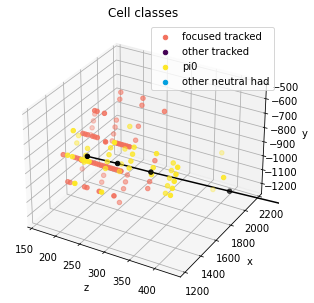

decay group: delta+_p


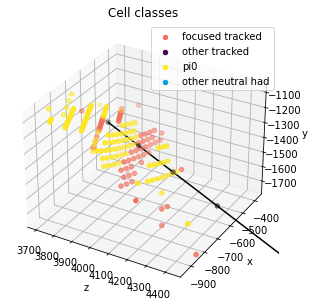

decay group: delta+_p


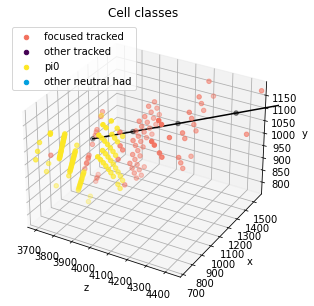

decay group: delta+_p


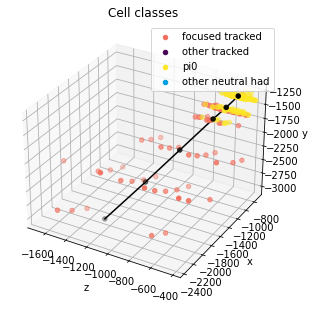

decay group: delta+_p


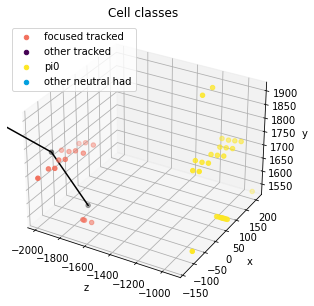

decay group: delta+_p


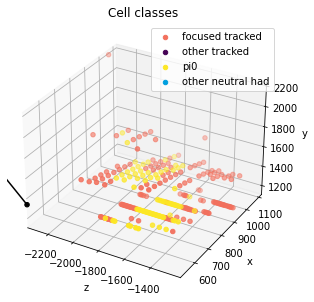

In [31]:
for event_idx in range(20):
    print("decay group:", decay_groups[processed_event_data["decay_group"][event_idx]])
    plot_proccessed_cells_in_line([processed_event_data["x"][event_idx]], [processed_event_data["y"][event_idx]], [processed_event_data["z"][event_idx]], [processed_event_data["cell_part_deposit_labels"][event_idx]], ["Cell classes"], "z", "x", "y", [None], [None], event_idx, add_track=True)

596


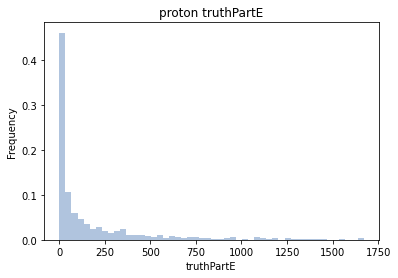

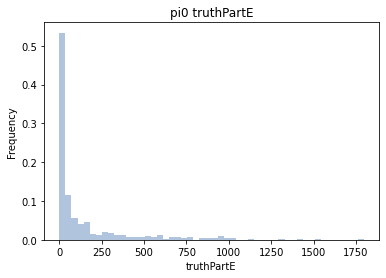

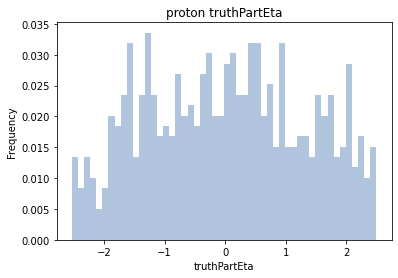

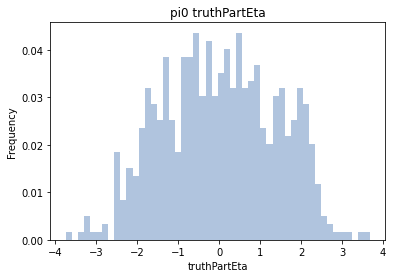

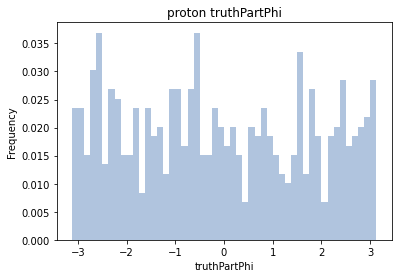

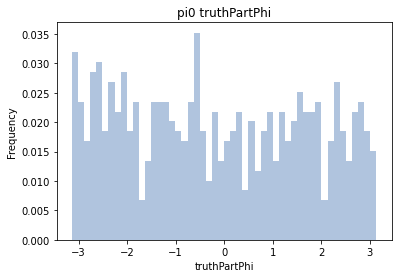

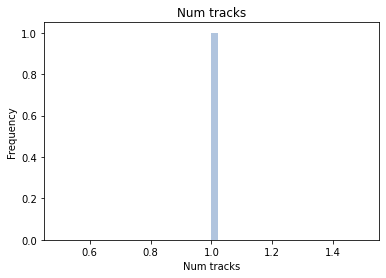

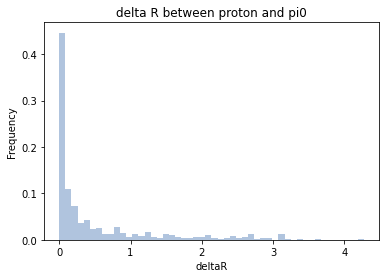

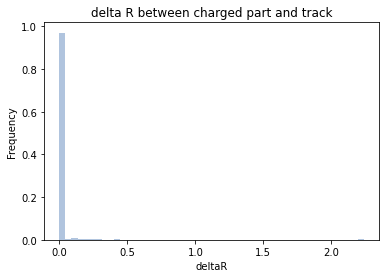

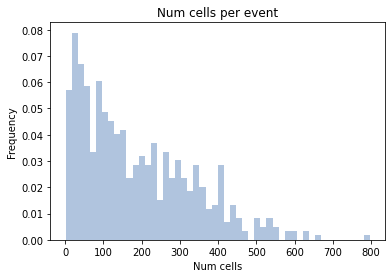

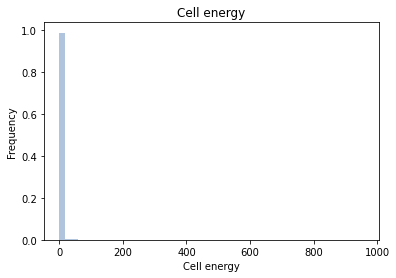

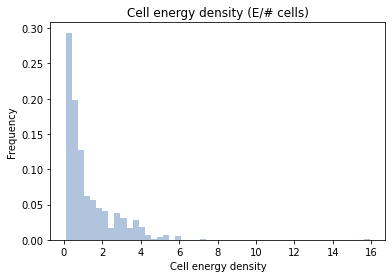

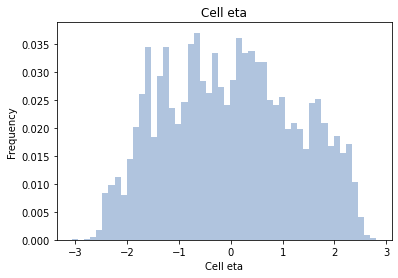

In [33]:
# Used to debug delta+ -> proton + pi0
for feat in ["trackP", "trackEta", "trackPhi", "truthPartE", "truthPartPt", "truthPartEta", "truthPartPhi"]:
    processed_event_data[feat] = ak.Array(processed_event_data[feat])

def measure_deltaR(phi1, eta1, p1, phi2, eta2, p2):
    vectors1 = vector.obj(eta=eta1, phi=phi1, rho=p1)
    vectors2 = vector.obj(eta=eta2, phi=phi2, rho=p2)

    return np.array(vectors1.deltaR(vectors2))

# pass events of rho or delta+->proton+pi0 s.t. particle IDs = [rho/delta, pipm/proton, pi0]
def plot_events_part_info(events_arr, part_names, colour="darkseagreen"):
    plot_feat = ["truthPartE", "truthPartEta", "truthPartPhi"]

    for feat in plot_feat:
        for i, part_idx in enumerate([1,2]):
            plot_hist(np.array(events_arr[feat][:, part_idx]), 50, part_names[i] + " " + feat, feat, "Frequency", colour=colour)

    # plot delta R feat
    charged_part_eta = events_arr["truthPartEta"][:, 1]
    neutral_part_eta = events_arr["truthPartEta"][:, 2]
    track_eta = events_arr["trackEta"][:, 0]

    charged_part_phi = events_arr["truthPartPhi"][:, 1]
    neutral_part_phi = events_arr["truthPartPhi"][:, 2]
    track_phi = events_arr["trackPhi"][:, 0]

    charged_part_p = events_arr["truthPartPt"][:, 1]
    neutral_part_p = events_arr["truthPartPt"][:, 2]
    track_p = events_arr["trackP"][:, 0]

    num_tracks = [len(trackP) for trackP in events_arr["trackP"]]
    plot_hist(num_tracks, 50, "Num tracks", "Num tracks", "Frequency", colour=colour)


    deltaR_parts = measure_deltaR(charged_part_phi, charged_part_eta, charged_part_p, neutral_part_phi, neutral_part_eta, neutral_part_p)
    deltaR_part_track = measure_deltaR(charged_part_phi, charged_part_eta, charged_part_p, track_phi, track_eta, track_p)

    plot_hist(deltaR_parts, 50, "delta R between " + part_names[0] + " and " + part_names[1], "deltaR", "Frequency", colour=colour)
    plot_hist(deltaR_part_track, 50, "delta R between charged part and track", "deltaR", "Frequency", colour=colour)

    # plot cell info
    n_cells_per_event = np.array([len(cell_E) for cell_E in events_arr["cell_E"]])
    plot_hist(n_cells_per_event, 50, "Num cells per event", "Num cells", "Frequency", colour=colour)
    plot_hist(flatten_layers(events_arr["cell_E"], 1), 50, "Cell energy", "Cell energy", "Frequency", colour=colour)
    plot_hist((np.array(events_arr["truthPartE"][:, 0])/n_cells_per_event)[n_cells_per_event != 0], 50, "Cell energy density (E/# cells)", "Cell energy density", "Frequency", colour=colour)

    plot_hist(flatten_layers(events_arr["cell_eta"], 1), 50, "Cell eta", "Cell eta", "Frequency", colour=colour)

print(len(processed_event_data["truthPartE"]))
plot_events_part_info(processed_event_data, ["proton", "pi0"], colour="lightsteelblue")
